##### In this notebook, we will try to use convolution-recurrent nural networks to solve sentiment classification problem. 

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16493370716127376110
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5892014080
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15804406568651630345
physical_device_desc: "device: 0, name: GeForce GTX 980 Ti, pci bus id: 0000:09:00.0, compute capability: 5.2"
]


Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.callbacks import TensorBoard
from time import time
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense,Dropout,Input,RNN,Embedding,LSTM,Conv1D,GlobalMaxPooling1D,Flatten,MaxPooling1D,GRU,SpatialDropout1D,Bidirectional, merge
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam, Adadelta
from keras.constraints import maxnorm
from keras.models import Model

##### Data preprocessing

In [3]:
train = pd.read_csv("./data/train.tsv", sep = "\t")
test = pd.read_csv("./data/test.tsv", sep = "\t")

In [4]:
train_text = train.Phrase
test_text = test.Phrase
total_reviews = list(train_text) + list(test_text)

In [5]:
tk = Tokenizer(lower=True, filters='')

In [6]:
tk.fit_on_texts(total_reviews)

In [7]:
word_index = tk.word_index

##### The max length of the reviews is 56

In [8]:
max_length = max([len(s.split()) for s in total_reviews])

In [9]:
train_tokenized = tk.texts_to_sequences(train_text)
test_tokenized = tk.texts_to_sequences(test_text)

In [10]:
y_train = train.Sentiment

##### The vocabulary size is 19479

In [11]:
vocab_size = len(tk.word_index) + 1

##### Padding each review to the same length

In [12]:
X_train = pad_sequences(train_tokenized, maxlen=max_length, padding='post')
X_test = pad_sequences(test_tokenized, maxlen=max_length, padding='post')

In [13]:
y = np.zeros([len(y_train), 5])

In [14]:
for i in range(len(y_train)):
    y[i,y_train[i]-1] = 1

##### Load GloVe Word Embedding pre-trained as the weight of our word vector

In [15]:
embeddings_index = {}
f = open(os.path.join('data', 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


###### Create word embedding vector

In [16]:
EMBEDDING_DIM = 100

In [17]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

The Embedding layer requires the specification of the vocabulary size **(vocab_size)**, the size of the real-valued vector space **EMBEDDING_DIM = 100**, and the maximum length of input documents **max_length** .

##### Start building the model

In [24]:
def BuildModel():
    main_input = Input(shape=(max_length, ), dtype='int32', name='main_input')
    embedding = Embedding(vocab_size, EMBEDDING_DIM, input_length = max_length, weights=[embedding_matrix], trainable=False, name='embedding')(main_input)
    embedding = Dropout(0.50)(embedding)
    conv1 = Conv1D(200, 4, border_mode = 'valid', subsample_length=1, activation='relu', name='conv1')(embedding)
    maxconv1 = MaxPooling1D(pool_size=2, name='maxconv1')(conv1)
    conv2 = Conv1D(200, 5, border_mode = 'valid', subsample_length=1, activation='relu', name='conv2')(embedding)
    maxconv2 = MaxPooling1D(pool_size=2, name='maxconv2')(conv2)
    x = merge([maxconv1, maxconv2], mode='concat')
    x = Dropout(0.15)(x)
    x = LSTM(64)(x)
    x = Dense(400, activation='relu', init='he_normal', W_constraint = maxnorm(3), b_constraint=maxnorm(3), name='mlp')(x)
    x = Dropout(0.10, name='drop')(x)
    output = Dense(5, init='he_normal', activation='softmax', name='output')(x)
    model = Model(input=main_input, output=output)
    model.compile(loss={'output':'categorical_crossentropy'}, optimizer=Adam(lr=0.001), metrics=["accuracy"])
    return model

In [18]:
def BuildCNNModel():
    model = Sequential()
    model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length = max_length, weights=[embedding_matrix], trainable=False,name = 'embedding'))
    model.add(Dropout(0.5, name = 'dropout1'))
    model.add(Conv1D(200, 4, border_mode = 'valid', subsample_length=1, activation='relu', name = 'conv1'))
    model.add(MaxPooling1D(pool_size=2, name = 'conv1_max'))
    model.add(Dropout(0.15, name = 'dropout2'))
    model.add(Flatten())
    model.add(Dense(5, activation='softmax', name = 'dense'))
    model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.001),metrics=['accuracy'])
    return model

In [18]:
def BuildRNNModel():
    model = Sequential()
    model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length = max_length, weights=[embedding_matrix], trainable=False,name = 'embedding'))
    model.add(Dropout(0.5, name = 'dropout1'))
    model.add(LSTM(64, name = 'lstm'))
    model.add(Dropout(0.15, name = 'dropout2'))
    model.add(Dense(5, activation='softmax', name = 'dense'))
    model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.001),metrics=['accuracy'])
    return model

In [19]:
tensorboard = TensorBoard(log_dir="logs/", histogram_freq=0,write_graph=True, write_images=True)

Instructions for updating:
Use the retry module or similar alternatives.


In [25]:
model = BuildModel()

/data/s2191989/anaconda3/envs/Zhao/lib/python3.5/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(200, 4, strides=1, name="conv1", padding="valid", activation="relu")`
  """
/data/s2191989/anaconda3/envs/Zhao/lib/python3.5/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(200, 5, strides=1, name="conv2", padding="valid", activation="relu")`
  import sys
/data/s2191989/anaconda3/envs/Zhao/lib/python3.5/site-packages/ipykernel_launcher.py:9: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  if __name__ == '__main__':
/data/s2191989/anaconda3/envs/Zhao/lib/python3.5/site-packages/keras/legacy/layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  na

In [20]:
CNN_model = BuildCNNModel()

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


/data/s2191989/anaconda3/envs/Zhao/lib/python3.5/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(200, 4, padding="valid", activation="relu", name="conv1", strides=1)`
  """


Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [20]:
RNN_model = BuildRNNModel()

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [23]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 56)           0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 56, 100)      1947900     main_input[0][0]                 
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 56, 100)      0           embedding[0][0]                  
__________________________________________________________________________________________________
conv1 (Conv1D)                  (None, 53, 200)      80200       dropout_1[0][0]                  
__________________________________________________________________________________________________
conv2 (Con

In [30]:
RNN_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 56, 100)           1947900   
_________________________________________________________________
dropout1 (Dropout)           (None, 56, 100)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                42240     
_________________________________________________________________
dropout2 (Dropout)           (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 1,990,465
Trainable params: 42,565
Non-trainable params: 1,947,900
_________________________________________________________________


In [31]:
CNN_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 56, 100)           1947900   
_________________________________________________________________
dropout1 (Dropout)           (None, 56, 100)           0         
_________________________________________________________________
conv1 (Conv1D)               (None, 53, 200)           80200     
_________________________________________________________________
conv1_max (MaxPooling1D)     (None, 26, 200)           0         
_________________________________________________________________
dropout2 (Dropout)           (None, 26, 200)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5200)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 26005     
Total para

In [26]:
model.fit(X_train, y, validation_split=0.2, epochs = 100, batch_size=5000, verbose=1, callbacks=[tensorboard])

Train on 124848 samples, validate on 31212 samples
Epoch 1/100
124848/124848 [==============================] - 10s 78us/step - loss: 1.3857 - acc: 0.5018 - val_loss: 1.2702 - val_acc: 0.4914
Epoch 2/100
124848/124848 [==============================] - 7s 55us/step - loss: 1.2144 - acc: 0.5164 - val_loss: 1.2004 - val_acc: 0.4972
Epoch 3/100
124848/124848 [==============================] - 7s 55us/step - loss: 1.1605 - acc: 0.5218 - val_loss: 1.1701 - val_acc: 0.5112
Epoch 4/100
124848/124848 [==============================] - 7s 55us/step - loss: 1.1426 - acc: 0.5321 - val_loss: 1.1681 - val_acc: 0.5187
Epoch 5/100
124848/124848 [==============================] - 7s 55us/step - loss: 1.1243 - acc: 0.5450 - val_loss: 1.1100 - val_acc: 0.5476
Epoch 6/100
124848/124848 [==============================] - 7s 55us/step - loss: 1.0959 - acc: 0.5559 - val_loss: 1.0854 - val_acc: 0.5564
Epoch 7/100
124848/124848 [==============================] - 7s 55us/step - loss: 1.0732 - acc: 0.5656 - val

Epoch 59/100
124848/124848 [==============================] - 7s 55us/step - loss: 0.8625 - acc: 0.6426 - val_loss: 0.9720 - val_acc: 0.5984
Epoch 60/100
124848/124848 [==============================] - 7s 55us/step - loss: 0.8605 - acc: 0.6443 - val_loss: 0.9666 - val_acc: 0.6003
Epoch 61/100
124848/124848 [==============================] - 7s 55us/step - loss: 0.8598 - acc: 0.6435 - val_loss: 0.9782 - val_acc: 0.5899
Epoch 62/100
124848/124848 [==============================] - 7s 55us/step - loss: 0.8596 - acc: 0.6440 - val_loss: 0.9823 - val_acc: 0.5898
Epoch 63/100
124848/124848 [==============================] - 7s 55us/step - loss: 0.8591 - acc: 0.6432 - val_loss: 0.9834 - val_acc: 0.5934
Epoch 64/100
124848/124848 [==============================] - 7s 55us/step - loss: 0.8620 - acc: 0.6451 - val_loss: 0.9756 - val_acc: 0.5940
Epoch 65/100
124848/124848 [==============================] - 7s 55us/step - loss: 0.8610 - acc: 0.6461 - val_loss: 0.9815 - val_acc: 0.5880
Epoch 66/100


In [21]:
CNN_model.fit(X_train, y, validation_split=0.2, epochs = 100, batch_size=5000, verbose=1, callbacks=[tensorboard])

Train on 124848 samples, validate on 31212 samples
Epoch 1/100
124848/124848 [==============================] - 4s 35us/step - loss: 1.3375 - acc: 0.4952 - val_loss: 1.2299 - val_acc: 0.5168
Epoch 2/100
124848/124848 [==============================] - 2s 19us/step - loss: 1.1679 - acc: 0.5382 - val_loss: 1.1596 - val_acc: 0.5298
Epoch 3/100
124848/124848 [==============================] - 2s 19us/step - loss: 1.1160 - acc: 0.5521 - val_loss: 1.1125 - val_acc: 0.5409
Epoch 4/100
124848/124848 [==============================] - 2s 19us/step - loss: 1.0851 - acc: 0.5616 - val_loss: 1.0815 - val_acc: 0.5494
Epoch 5/100
124848/124848 [==============================] - 2s 20us/step - loss: 1.0633 - acc: 0.5683 - val_loss: 1.0605 - val_acc: 0.5564
Epoch 6/100
124848/124848 [==============================] - 2s 19us/step - loss: 1.0456 - acc: 0.5743 - val_loss: 1.0462 - val_acc: 0.5628
Epoch 7/100
124848/124848 [==============================] - 2s 19us/step - loss: 1.0338 - acc: 0.5779 - val_

Epoch 59/100
124848/124848 [==============================] - 2s 20us/step - loss: 0.9142 - acc: 0.6298 - val_loss: 0.9899 - val_acc: 0.5870
Epoch 60/100
124848/124848 [==============================] - 2s 19us/step - loss: 0.9118 - acc: 0.6299 - val_loss: 0.9884 - val_acc: 0.5879
Epoch 61/100
124848/124848 [==============================] - 2s 19us/step - loss: 0.9114 - acc: 0.6316 - val_loss: 0.9873 - val_acc: 0.5900
Epoch 62/100
124848/124848 [==============================] - 2s 20us/step - loss: 0.9136 - acc: 0.6307 - val_loss: 0.9868 - val_acc: 0.5888
Epoch 63/100
124848/124848 [==============================] - 2s 20us/step - loss: 0.9110 - acc: 0.6326 - val_loss: 0.9894 - val_acc: 0.5861
Epoch 64/100
124848/124848 [==============================] - 2s 20us/step - loss: 0.9114 - acc: 0.6315 - val_loss: 0.9873 - val_acc: 0.5867
Epoch 65/100
124848/124848 [==============================] - 2s 20us/step - loss: 0.9110 - acc: 0.6324 - val_loss: 0.9892 - val_acc: 0.5854
Epoch 66/100


In [21]:
RNN_model.fit(X_train, y, validation_split=0.2, epochs = 100, batch_size=5000, verbose=1, callbacks=[tensorboard])

Train on 124848 samples, validate on 31212 samples
Epoch 1/100
124848/124848 [==============================] - 5s 39us/step - loss: 1.4596 - acc: 0.5039 - val_loss: 1.2799 - val_acc: 0.4923
Epoch 2/100
124848/124848 [==============================] - 4s 28us/step - loss: 1.2256 - acc: 0.5138 - val_loss: 1.2362 - val_acc: 0.4911
Epoch 3/100
124848/124848 [==============================] - 4s 28us/step - loss: 1.1903 - acc: 0.5151 - val_loss: 1.1986 - val_acc: 0.4931
Epoch 4/100
124848/124848 [==============================] - 4s 28us/step - loss: 1.1718 - acc: 0.5166 - val_loss: 1.1814 - val_acc: 0.4962
Epoch 5/100
124848/124848 [==============================] - 4s 28us/step - loss: 1.1608 - acc: 0.5194 - val_loss: 1.1712 - val_acc: 0.5007
Epoch 6/100
124848/124848 [==============================] - 4s 29us/step - loss: 1.1532 - acc: 0.5247 - val_loss: 1.1672 - val_acc: 0.5081
Epoch 7/100
124848/124848 [==============================] - 4s 29us/step - loss: 1.1450 - acc: 0.5323 - val_

Epoch 59/100
124848/124848 [==============================] - 4s 28us/step - loss: 0.9547 - acc: 0.6078 - val_loss: 0.9630 - val_acc: 0.6007
Epoch 60/100
124848/124848 [==============================] - 4s 29us/step - loss: 0.9565 - acc: 0.6064 - val_loss: 0.9708 - val_acc: 0.5977
Epoch 61/100
124848/124848 [==============================] - 4s 28us/step - loss: 0.9535 - acc: 0.6076 - val_loss: 0.9545 - val_acc: 0.6046
Epoch 62/100
124848/124848 [==============================] - 4s 29us/step - loss: 0.9535 - acc: 0.6071 - val_loss: 0.9531 - val_acc: 0.6055
Epoch 63/100
124848/124848 [==============================] - 4s 29us/step - loss: 0.9525 - acc: 0.6079 - val_loss: 0.9617 - val_acc: 0.6014
Epoch 64/100
124848/124848 [==============================] - 4s 29us/step - loss: 0.9528 - acc: 0.6076 - val_loss: 0.9649 - val_acc: 0.5991
Epoch 65/100
124848/124848 [==============================] - 4s 28us/step - loss: 0.9501 - acc: 0.6093 - val_loss: 0.9801 - val_acc: 0.5916
Epoch 66/100


In [53]:
model3.save("model3.h5")

In [54]:
model.save("cnn_rnn_model.h5")

In [55]:
RNN_model.save('rnn_model.h5')
CNN_model.save('cnn_model.h5')

In [30]:
model.load_weights("./model/cnn_rnn_model.h5")

In [31]:
model3.load_weights("./model/model3.h5")

In [32]:
CNN_model.load_weights("./model/cnn_model.h5")

In [33]:
RNN_model.load_weights("./model/rnn_model.h5")

In [56]:
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from IPython.display import SVG

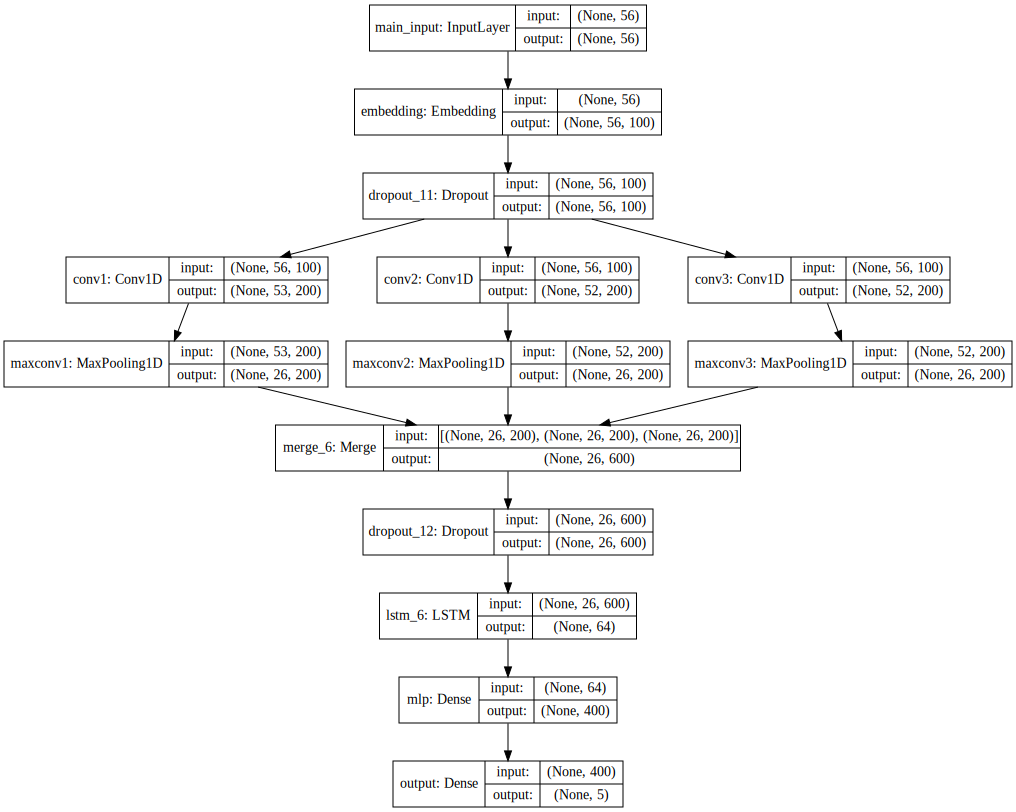

In [60]:
SVG(model_to_dot(model3, show_shapes=True).create(prog='dot', format='svg'))

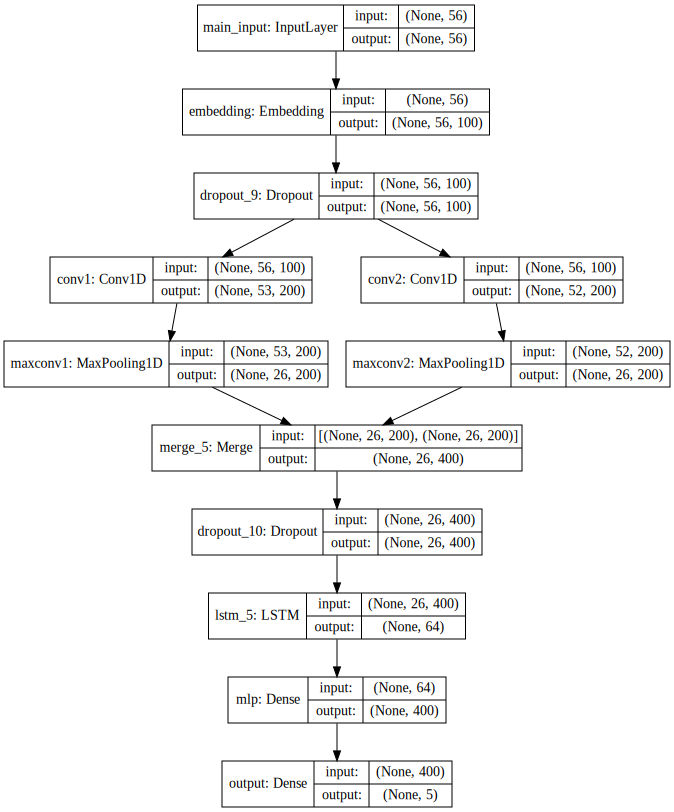

In [57]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

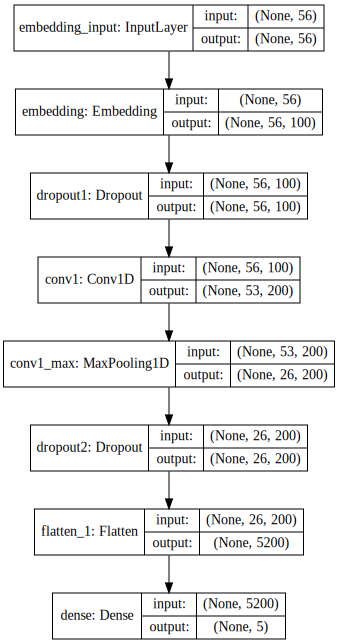

In [58]:
SVG(model_to_dot(CNN_model, show_shapes=True).create(prog='dot', format='svg'))

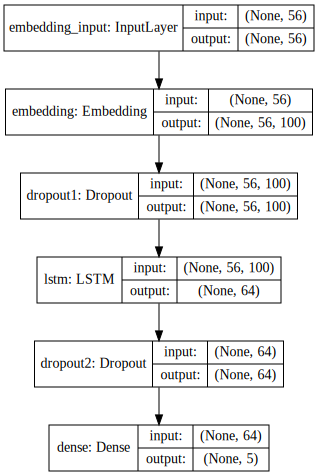

In [59]:
SVG(model_to_dot(RNN_model, show_shapes=True).create(prog='dot', format='svg'))